# Compares monthly met and precipitation statistics with Yang monthly data

Compares monthly met and precipitation statistics calculated from daily NPSNOW data with monthly data from Daqing Yang used in Yang 1999.

In [493]:
%matplotlib inline

In [494]:
import sys
sys.path.append('../source')

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import readers.npsnow as npsnow
from merge_npsnow_data import get_station_list, met_filename, get_precip, plot_station_met, merge_one_station
from constants import DATADIR

## Get list of station id

In [495]:
data_dir = '/home/apbarret/Data/NPSNOW/my_combined_met'
filelist = glob.glob(os.path.join(data_dir, 'npmet_??_combined.csv'))

## Merge met and precip data

In [496]:
def get_merged_data(sid):
    """Loads sub-daily meteorological data and resamples to daily.  Then combined me and precip data into
    a single dataframe.  Tmax, Tmin and wind speed at gauge height are then added
    """
    # Get data
    met = npsnow.read_met(met_filename(sid))
    precDay = get_precip(sid, set_noprecip_to_nan=False)
    snowDay = get_snowdepth(sid)
    snowDay = snowDay.where(snowDay.notnull(), 0.)
    # Convert to daily metrics
    metDay = met.resample('D').mean()
    metDay['TMIN'] = met['TAIR'].resample('D').min()
    metDay['TMAX'] = met['TAIR'].resample('D').max()
    # Merge data
    df = pd.concat([metDay, precDay, snowDay], axis=1, sort=False)
    df = df.rename({'amount': 'PRECIP', 'type': 'PTYPE', 'snowdepth': 'SDEPTH'}, axis=1)
    df = df.drop('statid', axis=1)  # Drop duplicate column
    # Calculate wind speed at gauge height
    df['Ug'] = df.apply(wind_at_gauge, axis=1)
    return df


def get_snowdepth(sid):
    """Returns snow depth for a given station"""
    snowstk_filename = os.path.join(DATADIR, 'snow', 'measured', 'snwstake.dat')
    snowDay = npsnow.read_snowstake(snowstk_filename)
    return snowDay[snowDay.station == int(sid)].snowdepth

def wind_at_gauge(x):
    """Reduces 10 m wind speed to wind at gauge height orifice"""
    H = 10.  # height of anenometer
    hg = 2.  # height of gauge orifice
    z0 = 0.01  # Roughness parameter of snow surface
    return x.WSPD * np.log10((hg- x.SDEPTH*0.01)/z0) / np.log10(H/z0)


met = npsnow.read_met(met_filename(sid))
np.round(met['1972-05-01'].TAIR.mean(), 1)

## Get daily met and precip data

In [497]:
sid = '31'
df = get_merged_data(sid)
df.head()

,Station_ID,Latitude,Longitude,TAIR,RH,SLP,WDIR,WSPD,TOTCLD,LOWCLD,TSURF,TMIN,TMAX,PRECIP,PTYPE,SDEPTH,Ug
1988-12-01,31.0,76.167000,-154.100000,-32.0750,79.625,1007.8000,336.25,5.125,6.625,1.125,-32.125,-33.5,-30.1,NaN,NaN,23.0,3.840288
1988-12-02,31.0,76.167000,-154.128000,-33.2625,79.125,1010.6875,283.75,4.625,1.625,0.000,-34.375,-35.5,-31.1,NaN,NaN,23.0,3.465625
1988-12-03,31.0,76.157250,-154.112500,-32.9000,79.125,1011.0000,256.25,4.625,5.375,0.000,-34.000,-33.9,-32.2,NaN,NaN,23.0,3.465625
1988-12-04,31.0,76.150000,-153.933375,-34.8125,78.000,1008.3000,195.00,4.000,2.125,0.000,-36.250,-36.8,-32.2,NaN,NaN,23.0,2.997298
1988-12-05,31.0,76.159375,-153.779125,-32.8000,79.250,1006.7875,180.00,5.125,7.250,0.000,-33.625,-36.5,-26.9,NaN,NaN,23.0,3.840288


def zscore(x, window=11):
    r = x.rolling(window, center=True)
    m = r.mean()
    s = r.std()
    return (x - m)/s
    

fig, ax = plt.subplots(3, 1, figsize=(12,7))

df[['WSPD', 'Ug']].plot(ax=ax[0])
df.SDEPTH.plot(ax=ax[1])
df.SDEPTH.rolling(11, center=True).mean().plot(ax=ax[1])
#zscore(df.SDEPTH, window=5).plot(ax=ax[2])
rdiff = df.SDEPTH.diff() / df.SDEPTH.rolling(11, center=True).mean()
rdiff.plot(ax=ax[2])

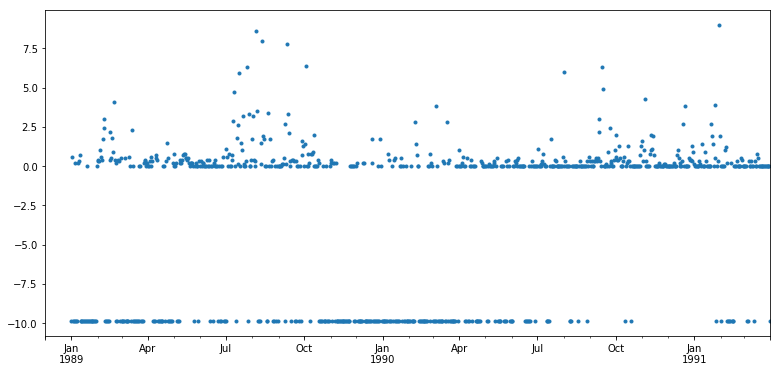

In [498]:
fig, ax = plt.subplots(figsize=(13,6))
df.PRECIP.plot(marker='.', linestyle='')

## Convert to monthly data

In [499]:
dfMon = pd.DataFrame({
    'ND': df.PRECIP.resample('MS').count(),
    'NU': df.Ug.resample('MS').count(),
    'NT': df.TAIR.resample('MS').count(),
    'Tmn': df.TAIR.resample('MS', label='left').mean(),
    'Ug': df.Ug.resample('MS', label='left').mean(),
    'DP': df.PRECIP[df.PRECIP > 0.].resample('MS').count(),
    'Dtc': df.PRECIP[df.PRECIP == 0.].resample('MS').count(),
    'Pg': df.PRECIP[df.PRECIP > 0].resample('MS').sum()
})
dfMon

,ND,NU,NT,Tmn,Ug,DP,Dtc,Pg
1988-12-01,0,31,31,-27.563710,3.659768,NaN,NaN,NaN
1989-01-01,31,31,31,-32.247984,4.825529,5.0,2.0,2.0
1989-02-01,28,28,28,-21.399107,4.870357,20.0,0.0,21.8
1989-03-01,31,31,31,-29.701210,3.900969,7.0,5.0,4.5
1989-04-01,30,30,30,-22.625417,3.721889,10.0,5.0,5.3
1989-05-01,31,31,31,-11.235484,3.302421,19.0,7.0,7.7
1989-06-01,30,30,30,-0.876667,4.955470,8.0,15.0,2.7
1989-07-01,31,31,31,0.085081,5.136545,19.0,9.0,37.7
1989-08-01,31,31,31,-0.474194,3.825579,15.0,7.0,36.7
1989-09-01,30,30,30,-6.567917,4.445854,16.0,8.0,22.0


In [500]:
pd.DataFrame({
    'ND': dfMon.ND.resample('AS').sum(min_count=12),
    'NU': dfMon.NU.resample('AS').sum(min_count=12),
    'Tmn': dfMon.Tmn.resample('AS').mean(),
    'Ug': dfMon.Ug.resample('AS').mean(),
    'DP': dfMon.DP.resample('AS').sum(min_count=12),
    'Dtc': dfMon.Dtc.resample('AS').sum(min_count=12),
    'Pg': dfMon.Pg.resample('AS').sum(min_count=12),
})

,ND,NU,Tmn,Ug,DP,Dtc,Pg
1988-01-01,NaN,NaN,-27.563710,3.659768,NaN,NaN,NaN
1989-01-01,365.0,365.0,-17.338331,4.281801,140.0,76.0,159.7
1990-01-01,365.0,365.0,-16.686864,3.869991,109.0,154.0,99.1
1991-01-01,NaN,NaN,-29.722321,3.837769,NaN,NaN,NaN


## Get Yang data

In [501]:
yang_diri = '/home/apbarret/Data/NPSNOW/yang_precip'
yangMon = npsnow.read_yang_updated(os.path.join(yang_diri, f'yang_np_precip_updated_coords_{sid}.csv'))
yangMon.index = yangMon.Date
yangMon

,Date,NP,ND,Tmn,Ug,DP,Dtc,snow%,Pg,windC,traceC,Pc,Lat,Lon
Date,,,,,,,,,,,,,,
1989-01-01,1989-01-01,31.0,31.0,-31.2,4.7,5.0,25.0,100.0,2.0,1.5,2.5,6.0,77.003226,204.363441
1989-02-01,1989-02-01,31.0,28.0,-20.3,4.7,19.0,8.0,100.0,21.3,20.3,0.8,42.4,77.481548,207.048214
1989-03-01,1989-03-01,31.0,31.0,-28.8,3.9,6.0,24.0,100.0,4.3,4.3,2.4,11.0,77.816667,209.067742
1989-04-01,1989-04-01,31.0,30.0,-22.2,3.6,9.0,20.0,100.0,5.1,2.6,2.0,9.7,78.090556,208.649444
1989-05-01,1989-05-01,31.0,31.0,-11.2,3.2,18.0,12.0,100.0,7.4,2.9,1.2,11.5,77.988172,208.917204
1989-06-01,1989-06-01,31.0,30.0,-0.9,4.8,8.0,21.0,100.0,2.7,1.4,2.1,6.2,78.583333,212.167222
1989-07-01,1989-07-01,31.0,31.0,0.1,5.0,18.0,12.0,60.6,37.3,14.7,1.2,53.2,78.617204,217.553763
1989-08-01,1989-08-01,31.0,31.0,-0.4,3.6,15.0,15.0,20.7,36.7,5.1,1.5,43.3,78.944624,219.314516
1989-09-01,1989-09-01,31.0,30.0,-6.5,4.1,15.0,14.0,62.3,20.7,7.1,1.4,29.2,78.625556,219.621667


## Plot time series

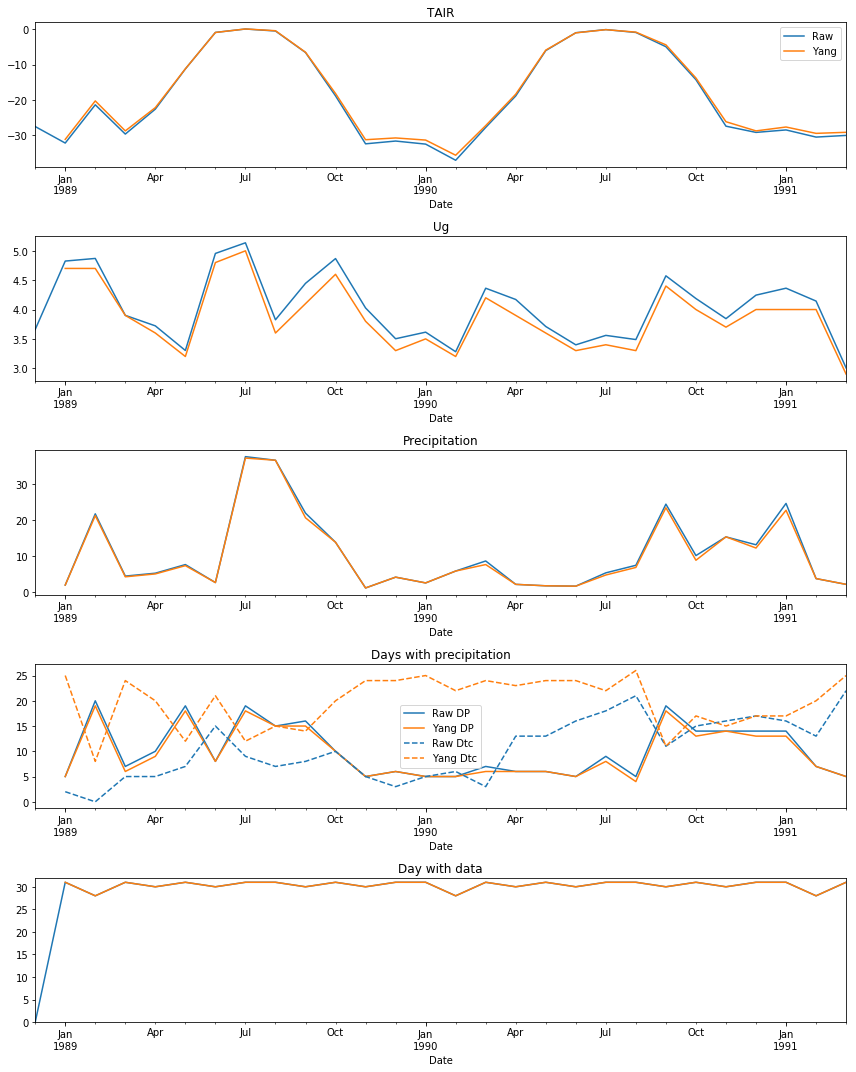

In [502]:
fig, ax = plt.subplots(5, 1, figsize=(12,15))

myb = '#1f77b4'
myo = '#ff7f0e'

# Mean temperature
dfMon.Tmn.plot(ax=ax[0], label='Raw', color=myb)
yangMon.Tmn.plot(ax=ax[0], label='Yang', color=myo)
ax[0].legend()
ax[0].set_title('TAIR')

# Wind as gauge
dfMon.Ug.plot(ax=ax[1], color=myb)
yangMon.Ug.plot(ax=ax[1], color=myo)
ax[1].set_title('Ug')

# Precipitation
dfMon.Pg.plot(ax=ax[2], c=myb)
yangMon.Pg.plot(ax=ax[2], c=myo)
ax[2].set_title('Precipitation')

# Days with precipitation and trace
dfMon.DP.plot(ax=ax[3], label='Raw DP', c=myb)
yangMon.DP.plot(ax=ax[3], label='Yang DP', c=myo)
dfMon.Dtc.plot(ax=ax[3], ls='--', label='Raw Dtc', c=myb)
yangMon.Dtc.plot(ax=ax[3], ls='--', label='Yang Dtc', c=myo)
ax[3].legend()
ax[3].set_title('Days with precipitation')

dfMon.ND.plot(ax=ax[4], c=myb)
yangMon.ND.plot(ax=ax[4], c=myo)
ax[4].set_ylim(0,32)
ax[4].set_title('Day with data')

plt.tight_layout()